In [30]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype']        = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_data      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/data'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [31]:
# Grab data from databases for plotting GHG emissions
def _load_GHG_emissions(scen_labels_):

    # Load GHG emissions table and process them from database
    def __load_GHG_from_csv(df_, scenario):

        df_['carbon_emissions_tons'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['carbon_emissions_tons']

        df_ = df_[['period', 'load_zone', 'carbon_emissions_tons']]
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                                                          
        df_['scenario'] = scenario     
        
        return df_
    
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['static_load_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_ = df_[['period', 'load_zone', 'static_load_mw']]
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_.rename(columns = {'static_load_mw': 'load_mw'})

    dfs_  = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        # Load GHG emissions from cvs files
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        emissions_ = __load_GHG_from_csv(dispatch_, scen)
        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)

        dfs_.append(pd.merge(emissions_, load_, on  = ['period', 'load_zone', 'scenario']))
    
    df_                          = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']                = df_['period'].astype(int)
    df_['carbon_emissions_tons'] = df_['carbon_emissions_tons'].astype(float)
    df_['load_mw']               = df_['load_mw'].astype(float)
    
    return df_

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_clean_energy(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario, zone):
        
        techs_ = ['CCGT', 
                  'CT', 
                  'Diesel', 
                  'Nuclear',
                  'Supercritical_Coal', 
                  'Subcritical_Coal_Large', 
                  'Subcritical_Coal_Small']
        
        stor_ = ['Battery', 
                 'Hydrogen', 
                 'Hydro_Pumped']

        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_ = df_[['period', 'technology', 'load_zone', 'power_mw']]
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_                          = df_.loc[~df_['technology'].isin(stor_)].reset_index(drop = True)
        idx_                         = df_['technology'].isin(techs_)
        df_.loc[~idx_, 'technology'] = 'clean'
        df_.loc[idx_, 'technology']  = 'no_clean'
        df_                          = df_.reset_index(drop = True)

        df_['scenario'] = scenario
                
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scenario, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scenario, path)
        
        dir_name   = r'{}/{}'.format(path, scenario)
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_dispatch_from_csv(dispatch_, scenario, zone)]
        
    df_             = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']   = df_['period'].astype(int)
    df_['power_mw'] = df_['power_mw'].astype(float)
    
    return df_

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_losses(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_stor_losses_from_csv(df_, scenario):
        techs_ = ['Battery', 'Hydro_Pumped', 'Hydrogen']
        
        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_  = df_[['period', 'technology', 'load_zone', 'power_mw']]
        idx_ = df_['technology'].isin(techs_)
        
        df_.loc[idx_, 'technology']  = 'stor_losses'
        df_.loc[~idx_, 'technology'] = 'gen'
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_

    def __load_tx_losses_from_csv(df_, scenario):
        
        df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']

        df_1_ = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_2_ = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()

        df_1_['technology'] = 'tx_losses'
        df_2_['technology'] = 'tx_losses'

        df_1_ = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                        'load_zone_to': 'load_zone'})

        df_2_ = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                        'load_zone_from': 'load_zone'})
        
        df_ = pd.concat([df_1_, df_2_], axis = 0)
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name  = r'{}/{}'.format(path, scen)
        dispatch_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)

        dfs_ += [__load_stor_losses_from_csv(dispatch_, scen)]
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting LCOE emissions
def _load_cost(scen_labels_):
    # Load fuel, and operation and maintanace cost table and process data from database
    def __load_vr_cost_from_csv(df_, scenario):
        
        df_['variable_om_cost'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['variable_om_cost']
         
        df_ = df_[['period', 'load_zone', 'variable_om_cost']]
        df_ = df_.rename(columns = {'variable_om_cost': 'variable_cost'})
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_

    # Load fix capacity cost table and process data from database
    def __load_fx_cost_from_csv(project_, new_, spec_, scenario):
        
        new_ = new_.fillna({'capacity_cost': 0, 'fixed_cost': 0})
        
        new_['new_fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']

        new_ = new_[['period', 'load_zone', 'new_fixed_cost']]
        new_ = new_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                                 
        spec_['spec_fixed_cost'] = spec_['fixed_cost_per_mw_yr'] 

        spec_ = pd.merge(spec_, project_, on = ['project'])
        spec_ = spec_[['period', 'load_zone', 'spec_fixed_cost']]
        spec_ = spec_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_               = pd.merge(new_, spec_, on = ['period', 'load_zone'])
        df_['fixed_cost'] = df_['new_fixed_cost'] + spec_['spec_fixed_cost']
        df_               = df_[['period', 'load_zone', 'fixed_cost']]
        df_['scenario']   = scenario    

        return df_

#     # Load transmission capacity cost table and process data from database
#     def __load_tx_cost_from_csv(project_, new_, spec_, scenario):

#         new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']
        
#         new_ = new_[['period', 'load_zone_from', 'fixed_cost']]
#         new_ = new_.rename(columns = {'load_zone_from': 'load_zone', 'fixed_cost': 'tx_cost'})
#         new_ = new_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
        
#         #new_['scenario'] = scenario    
            
#         project_['transmission_line'] = project_['transmission_line'].str.replace('_new', '')
#         spec_                         = pd.merge(spec_, project_, on = ['transmission_line'])
#         spec_                         = spec_[['period', 'transmission_line', 'tx_annualized_real_cost_per_mw_yr', 'specified_tx_max_mw']]
#         spec_['transmission_line']    = spec_['transmission_line'].apply(lambda x: x.split("-")[0])
#         spec_                         = spec_.rename(columns = {'transmission_line': 'load_zone'})
#         spec_['spec_tx_cost']         = spec_['tx_annualized_real_cost_per_mw_yr'] * spec_['specified_tx_max_mw']
#         spec_                         = spec_[['period', 'load_zone', 'spec_tx_cost']]

#         df_             = pd.merge(new_, spec_, on = ['period', 'load_zone'])
#         df_['tx_cost']  = df_['tx_cost'] + spec_['spec_tx_cost']
#         df_             = df_[['period', 'load_zone', 'tx_cost']]
#         df_['scenario'] = scenario    
        
#         return df_

    # Load transmission capacity cost table and process data from database
    def __load_tx_cost_from_csv(project_, new_, scenario):

        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']
        
        new_ = new_[['period', 'transmission_line', 'max_mw', 'fixed_cost']]
        new_ = new_.rename(columns = {'max_mw': 'power_mw'})
        df_  = new_.groupby(['period', 
                             'transmission_line']).sum().reset_index(drop = False)
        project_ = project_.loc[project_['vintage'] == 2020].reset_index(drop = False)
        project_ = project_[['transmission_line', 'tx_annualized_real_cost_per_mw_yr']]
        
#         project_p_                      = project_.copy()
#         project_p_['transmission_line'] = project_p_['transmission_line'].str.replace('_new', '')
#         project_ = pd.concat([project_, project_p_], axis = 0).reset_index(drop = True)

        df_                  = pd.merge(df_, project_, on = ['transmission_line'])
        df_['capacity_cost'] = df_['tx_annualized_real_cost_per_mw_yr']*df_['power_mw']
        df_['load_zone']     = df_['transmission_line'].apply(lambda x: x.split("-")[0])
        df_                  = df_[['period', 'load_zone', 'capacity_cost', 'fixed_cost']]
        df_                  = df_.groupby(['period', 
                                            'load_zone']).agg({'capacity_cost': 'sum', 
                                                               'fixed_cost': 'sum'}).reset_index(drop = False)
        df_['tx_cost']    = df_['capacity_cost'] + df_['fixed_cost']
        df_               = df_[['period', 'load_zone', 'tx_cost']]
        df_['technology'] = 'Tx_Losses'    
        df_['scenario']   = scenario    
                
        return df_
    
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['static_load_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_ = df_[['period', 'load_zone', 'static_load_mw']]
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_.rename(columns = {'static_load_mw': 'load_mw'})

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)        

        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)
        
        # Load fix costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/project_period.csv', low_memory = False)
        spec_    = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_ = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        fx_      = __load_fx_cost_from_csv(project_, new_, spec_, scen)
        
        # Load variables costs from csv files
        vr_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        vr_ = __load_vr_cost_from_csv(vr_, scen)
        
        # Load tx costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/transmission_period.csv', low_memory = False) 
        project_ = pd.read_csv(dir_name + r'/inputs/new_build_transmission_vintage_costs.tab', sep = '\t', engine = 'python')
        tx_      = __load_tx_cost_from_csv(project_, new_, scen)
        
        df_1_ = pd.merge(vr_, fx_, on = ['scenario', 'period', 'load_zone'])
        df_2_ = pd.merge(tx_, load_, on = ['scenario', 'period', 'load_zone'])
        df_   = pd.merge(df_1_, df_2_, on = ['scenario', 'period', 'load_zone'])

        dfs_.append(df_)
    
    df_                  = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']        = df_['period'].astype(int)
    df_['load_mw']       = df_['load_mw'].astype(float)
    df_['tx_cost']       = df_['tx_cost'].astype(float)
    df_['fixed_cost']    = df_['fixed_cost'].astype(float)
    df_['variable_cost'] = df_['variable_cost'].astype(float)

    return df_

# Grab data from databases for plotting LCOE emissions
def _load_land_use(scen_labels_):
 
    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario):
        
        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_ = df_[['period', 
                   'technology', 
                   'load_zone', 
                   'power_mw']]
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_

    # Load fix capacity cost table and process data from database
    def __load_capacity_from_csv(df_, scenario):  

        df_ = df_[['period', 
                   'technology', 
                   'load_zone', 
                   'capacity_mw', 
                   'energy_capacity_mwh']]

        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'capacity_mw': 'sum', 
                                              'energy_capacity_mwh': 'sum'})

        df_ = df_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_['scenario'] = scenario

        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)        

        # Load fix costs from csv files
        project_ = pd.read_csv(dir_name + f'/results/project_period.csv', low_memory = False)
        df_1_    = __load_capacity_from_csv(project_, scen)

        # Load variables costs from csv files
        dispatch_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        df_2_     = __load_dispatch_from_csv(dispatch_, scen)

        dfs_ += [pd.merge(df_1_, df_2_, on = ['scenario', 'technology', 'period', 'load_zone'])]
    
    df_                  = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']        = df_['period'].astype(int)
    df_['capacity_mw']   = df_['capacity_mw'].astype(float)
    df_['capacity_mwh']  = df_['capacity_mwh'].astype(float)
    df_['power_mw']      = df_['power_mw'].astype(float)

    return df_

In [32]:
def _group_emissions_by_zone(df_, scen_labels_, 
                             columns_ = ['period', 'scenario', 'load_zone']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], 
                          scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                          = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']                = df_['period'].astype(int)
    df_['carbon_emissions_tons'] = df_['carbon_emissions_tons'].astype(float)
    df_['load_mw']               = df_['load_mw'].astype(float)

    return df_

def _group_clean_energy_by_zone(df_, scen_labels_, columns_ = ['period', 'scenario', 'technology', 'load_zone']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_             = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']   = df_['period'].astype(int)
    df_['power_mw'] = df_['power_mw'].astype(float)

    return df_

def _group_cost_by_zone(df_, scen_labels_, columns_ = ['period', 'scenario', 'load_zone']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                  = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']        = df_['period'].astype(int)
    df_['load_mw']       = df_['load_mw'].astype(float)
    df_['tx_cost']       = df_['tx_cost'].astype(float)
    df_['fixed_cost']    = df_['fixed_cost'].astype(float)
    df_['variable_cost'] = df_['variable_cost'].astype(float)

    return df_

def _group_land_use_by_zone(df_, scen_labels_, land_use_, columns_ = ['period', 
                                                                      'scenario', 
                                                                      'technology', 
                                                                      'load_zone']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                 = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']       = df_['period'].astype(int)
    df_['capacity_mw']  = df_['capacity_mw'].astype(float)
    df_['capacity_mwh'] = df_['capacity_mwh'].astype(float)
    df_['power_mw']     = df_['power_mw'].astype(float)

    df_['area_m2'] = 0.
    for tech in df_['technology'].unique():
        idx_ = df_['technology'] == tech        
        df_.loc[idx_, 'area_m2'] = land_use_.loc[tech, 'land_use_intensity'] * df_.loc[idx_, land_use_.loc[tech, 'type']]


    land_use_['land_use_intensity'] = land_use_['land_use_intensity'].astype(float)
    
    return df_

In [38]:
# Plot GHG emissions for different scenarios
def _plot_carbon_emissions(ax, df_, scen_labels_, title  = '', 
                                                  units  = 1e6,
                                                  legend = False):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['carbon_emissions_tons'].to_numpy()
        
        ax.plot(x_[idx_], y_[idx_]/units, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)

    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'GHG Emissions (MtCO$_2$)', fontsize = 18)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #ax.set_ylim(0, 100)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenarios',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)

# Plot GHG emissions for different scenarios
def _plot_carbon_emissions_intesity(ax, df_, scen_labels_, title  = '', 
                                                           legend = False):

    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['carbon_emissions_tons'].to_numpy()
        z_    = data_['load_mw'].to_numpy()

        ax.plot(x_[idx_], y_[idx_]/z_[idx_], 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)

    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'GHG Emissions Intensity (MtCO$_2$/MWh)', fontsize = 18)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #ax.set_ylim(0, .1)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenarios',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)  
    
# Plot system cost for different scenarios
def _plot_total_cost(ax, df_, scen_labels_, legend = False,
                                             units  = 1e9,
                                             title  = ''):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['variable_cost'].to_numpy() + data_['fixed_cost'].to_numpy() + data_['tx_cost'].to_numpy() 
        z_    = data_['load_mw'].to_numpy()

        ax.plot(x_[idx_], y_[idx_]/units, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    #ax.set_ylabel(r'Costs (USD per MWh)', fontsize = 18)
    ax.set_ylabel(r'Costs (Billions USD)', fontsize = 18)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)

# Plot levelized cost of electricity for different scenarios
def _plot_levelized_cost(ax, df_, scen_labels_, legend = False,
                                                title  = ''):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['variable_cost'].to_numpy() + data_['fixed_cost'].to_numpy() + data_['tx_cost'].to_numpy() 
        z_    = data_['load_mw'].to_numpy()

        ax.plot(x_[idx_], y_[idx_]/z_[idx_], 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'Costs (USD per MWh)', fontsize = 18)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)

# Plot clean energy fraction (%) for different scenarios
def _plot_clean_energy(ax, df_, scen_labels_, 
                       legend = False,
                       title  = ''):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()   
        data_ = data_.sort_values(by = ['period'])
        x_    = data_.loc[data_['technology'] == 'clean', 'period'].to_numpy()
        y_    = data_.loc[data_['technology'] == 'clean', 'power_mw'].to_numpy()
        z_    = data_.loc[data_['technology'] == 'no_clean', 'power_mw'].to_numpy()
        
        ax.plot(x_, 100.*y_/(y_ + z_), 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_, x_)
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'Clean Energy (%)', fontsize = 18)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)
    
# Plot syestem losses (%) for different scenarios
def _plot_losses(ax, df_, scen_labels_, 
                 legend = False,
                 title  = ''):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()   
        data_ = data_.sort_values(by = ['period'])

        x_ = data_.loc[data_['technology'] == 'gen', 'period'].to_numpy()
        y_ = data_.loc[data_['technology'] == 'tx_losses', 'power_mw'].to_numpy()
        z_ = data_.loc[data_['technology'] == 'stor_losses', 'power_mw'].to_numpy()
        w_ = data_.loc[data_['technology'] == 'gen', 'power_mw'].to_numpy()

        ax.plot(x_, - 100.*(y_ + z_)/w_, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_, x_)
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'System Losses (%)', fontsize = 18)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)
    
# Plot land use (MHa) for different scenarios
def _plot_land_use(ax, df_, scen_labels_, 
                   ylabel = r'Land Use (MHa)',
                   units  = 1e6,
                   legend = False,
                   title  = ''):
    
    df_p_ = df_[['period', 'scenario', 'load_zone', 'area_m2']].copy()
    df_p_ = df_p_.groupby(['period', 'scenario', 'load_zone']).sum().reset_index(drop = False)

    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_p_.loc[(df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)].copy()   
        data_ = data_.sort_values(by = ['period'])

        x_ = data_['period'].to_numpy()
        y_ = data_['area_m2'].to_numpy()

        ax.plot(x_, 0.0001*y_/units, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_, x_)
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 18)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)
    
    
# Plot available land (%) for different scenarios
def _plot_available_land(ax, df_, scen_labels_, 
                         ylabel = r'Total Land Used Area (%)',
                         units  = 1e6,
                         legend = False,
                         title  = ''):
    
    df_p_ = df_[['period', 'scenario', 'load_zone', 'area_m2']].copy()
    df_p_ = df_p_.groupby(['period', 'scenario', 'load_zone']).sum().reset_index(drop = False)

    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_p_.loc[(df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)].copy()   
        data_ = data_.sort_values(by = ['period'])

        x_ = data_['period'].to_numpy()
        y_ = data_['area_m2'].to_numpy()

        ax.plot(x_, 100.*(0.0001*y_/units)/328.7, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_, x_)
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 18)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    ax.set_title(title, fontsize = 18, 
                        y        = 0.9125)

In [39]:
scen_labels_ = pd.read_csv(path_to_csvs + '/policy_pier-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

land_use_intensity_ = pd.read_csv(path_to_data + r'/land_use.csv', index_col = 0)

# Mosaic

In [ ]:
emissions_         = _load_GHG_emissions(scen_labels_)
grouped_emissions_ = _group_emissions_by_zone(emissions_, scen_labels_)
cost_              = _load_cost(scen_labels_)
grouped_cost_      = _group_cost_by_zone(cost_, scen_labels_)
clean_             = _load_clean_energy(scen_labels_)
grouped_clean_     = _group_clean_energy_by_zone(clean_, scen_labels_)
losses_            = _load_losses(scen_labels_)
grouped_losses_    = _group_clean_energy_by_zone(losses_, scen_labels_)
land_use_          = _load_land_use(scen_labels_)
grouped_land_use_  = _group_land_use_by_zone(land_use_, scen_labels_, land_use_intensity_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy


In [ ]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd'],
                               ['e', 'f', 'g', 'h']], layout      = 'constrained', 
                                                      figsize     = (20, 10), 
                                                      gridspec_kw = {'width_ratios': [1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')
    
# Plot GHG emissions for different scenarios
_plot_carbon_emissions(_ax['a'], grouped_emissions_, scen_labels_, legend = False)

# Plot GHG emissions for different scenarios
_plot_carbon_emissions_intesity(_ax['b'], grouped_emissions_, scen_labels_, legend = False)

# Plot system cost for different scenarios
_plot_total_cost(_ax['c'], grouped_cost_, scen_labels_, legend = False)

# Plot levelized cost of electricity for different scenarios
_plot_levelized_cost(_ax['d'], grouped_cost_, scen_labels_, legend = False)
    
# Plot land use for different scenarios
_plot_land_use(_ax['e'], grouped_land_use_, scen_labels_, legend = False)

# Plot land use share for different scenarios
_plot_available_land(_ax['f'], grouped_land_use_, scen_labels_, legend = False)

# Plot renewable portfolio for different scenarios
_plot_clean_energy(_ax['g'], grouped_clean_, scen_labels_, legend = False)
    
# Plot system losses for different scenarios
_plot_losses(_ax['h'], grouped_losses_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/policy_pier-line_plots.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Carbon Emissions

In [ ]:
emissions_         = _load_GHG_emissions(scen_labels_)
grouped_emissions_ = _group_emissions_by_zone(emissions_, scen_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


### Total System Carbon Emission

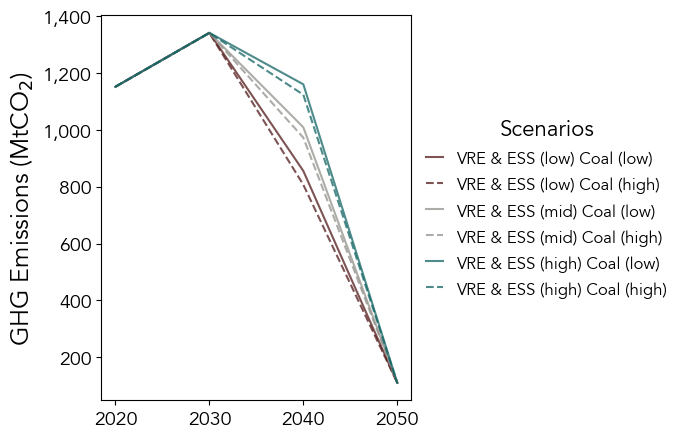

In [ ]:
fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot GHG emissions for different scenarios
_plot_carbon_emissions(_ax, grouped_emissions_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/carbon_emissions.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

### Carbon Emission Intensity

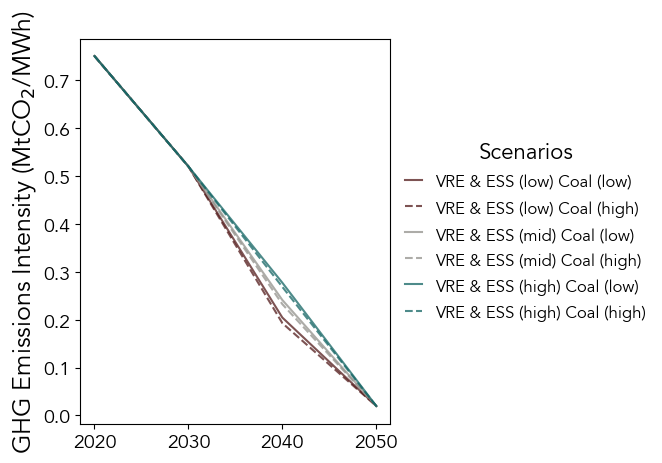

In [ ]:
fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot GHG emissions for different scenarios
_plot_carbon_emissions_intesity(_ax, grouped_emissions_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/carbon_emissions_intensity.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# System Costs

In [21]:
cost_         = _load_cost(scen_labels_)
grouped_cost_ = _group_cost_by_zone(cost_, scen_labels_)

grouped_cost_['tx_cost'] += 5.9e9

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


### Total System Cost

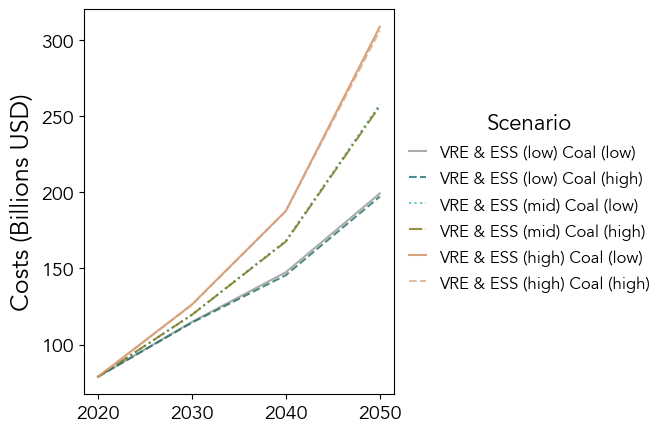

In [22]:
fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot system cost for different scenarios
_plot_total_cost(_ax, grouped_cost_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/cost.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

### Levelized System Cost

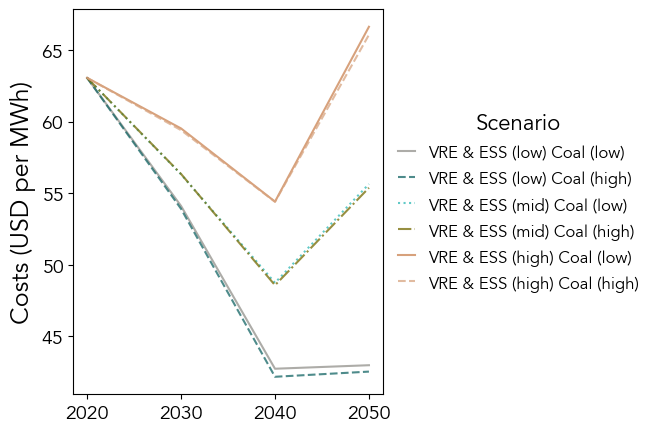

In [23]:
fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot levelized cost of electricity for different scenarios
_plot_levelized_cost(_ax, grouped_cost_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/levelized_cost.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Clean Energy

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


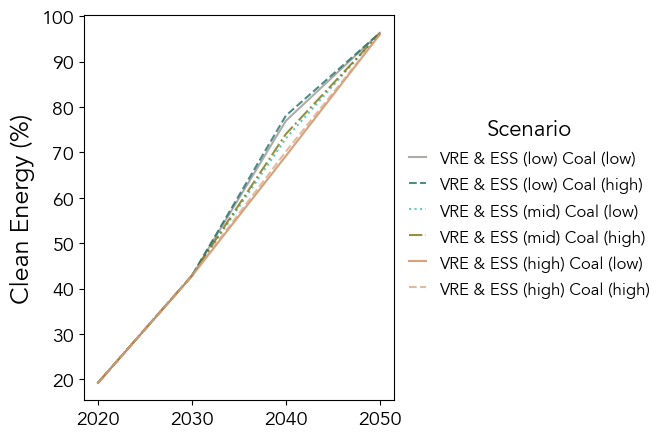

In [26]:
clean_energy_         = _load_clean_energy(scen_labels_)
grouped_clean_energy_ = _group_clean_energy_by_zone(clean_energy_, scen_labels_)

fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot levelized cost of electricity for different scenarios
_plot_clean_energy(_ax, grouped_clean_energy_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/clean_energy.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# System Loses

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
    period                                           scenario   technology  \
0     2020  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...          gen   
1     2020  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  stor_losses   
2     2020  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...    tx_losses   
3     203

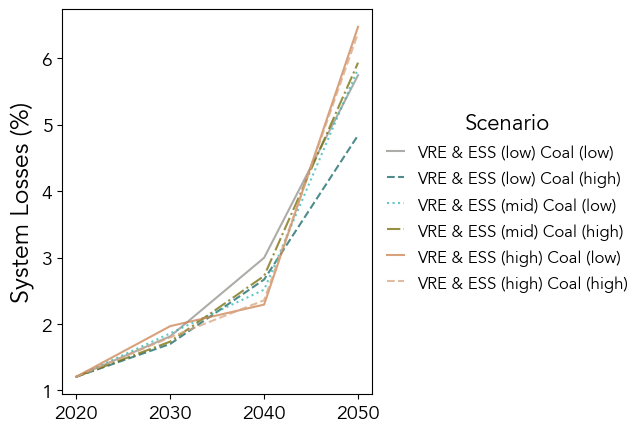

In [6]:
losses_         = _load_losses(scen_labels_)
grouped_losses_ = _group_clean_energy_by_zone(losses_, scen_labels_)
print(grouped_losses_)

fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot levelized cost of electricity for different scenarios
_plot_losses(_ax, grouped_losses_, scen_labels_, legend = True)

plt.savefig(path_to_images + '/losses.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Land Use

In [7]:
land_use_           = _load_land_use(scen_labels_)
land_use_intensity_ = pd.read_csv(path_to_data + r'/land_use.csv', index_col = 0)
grouped_land_use_   = _group_land_use_by_zone(land_use_, scen_labels_, land_use_intensity_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


### Land Used

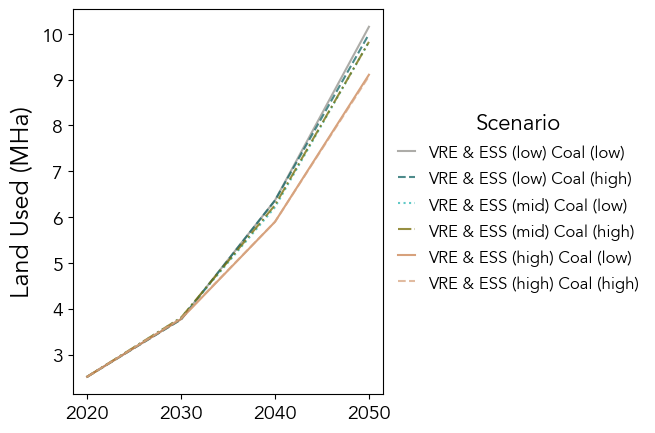

In [8]:
fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot land use for different scenarios
_plot_land_use(_ax, grouped_land_use_, scen_labels_, 
               ylabel = r'Land Used (MHa)',
               legend = True)

plt.savefig(path_to_images + '/land_use.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

### Total Land Used Area

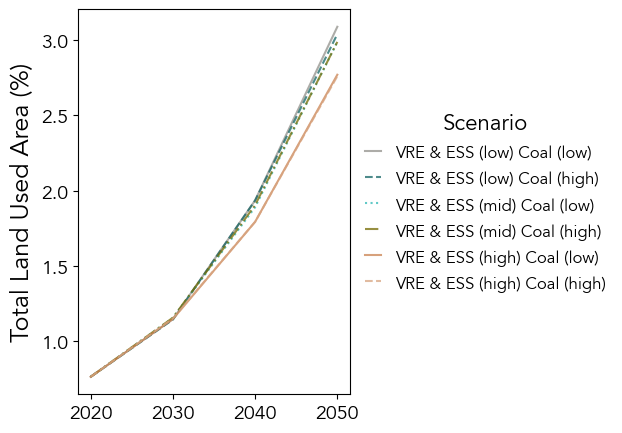

In [13]:
fig = plt.figure(figsize = (3.5, 5))
_ax  = plt.subplot(111)
    
# Plot land use for different scenarios
_plot_available_land(_ax, grouped_land_use_, scen_labels_, 
                     ylabel = r'Total Land Used Area (%)',
                     legend = True)

plt.savefig(path_to_images + '/available_land.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Installation Solar and Wind Rate...